In [1]:
# Fitting and Chi2 examples

In [2]:
# Boilerplate
%matplotlib inline
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize

In [3]:
# Generate Nsignal events according to a Guassian distribution 
mu = 10.
sig = 3.
Nsignal=1000
ssig  = np.random.normal(mu,sig,Nsignal)

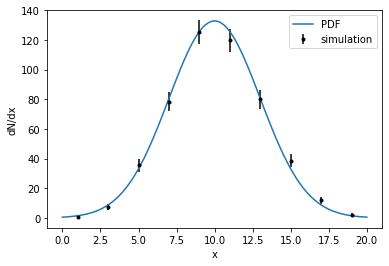

In [4]:
# Histogram them with arbitrary bin sizes
plotrange = (0.,20)
Nbins = 10
hist,bins = np.histogram(ssig,Nbins,plotrange)
hist_error = np.sqrt(hist)
hist_error = np.clip(hist_error,1.,None) # If the sqrt is 0, set it to 1.
binsize = bins[1]-bins[0]
binloc = bins[0:-1]+.5*binsize    # Move location to the middle of the bin
hist = hist/binsize               # Normalize
hist_error = hist_error/binsize   # Normalize error
plt.errorbar(binloc, hist, hist_error, fmt="k.", 
             label="simulation")
xlin = np.linspace(0.,20.,101)
pl=plt.plot(xlin,Nsignal*stats.norm.pdf(xlin,loc=mu,scale=sig),label="PDF")
xl=plt.xlabel("x")
yl=plt.ylabel("dN/dx")
leg = plt.legend()

In [5]:
# Define a chi2 function
def chi2(y,ypred,yerr=None):
    if yerr is not None:
        w=1./yerr**2         # If errors specified, the the weight is the inverse square
    else:
        w=1.
    return (w*(y-ypred)**2).sum()

In [6]:
# Let's see how well this represents the points.
pred = Nsignal*stats.norm.pdf(binloc,loc=mu,scale=sig) #Create a prediction for each bin
NDF = Nbins - 1  # Not a fit, but the normalization is a constraint
print('Chi2/NDF = ',chi2(hist,pred,hist_error)/NDF)

Chi2/NDF =  0.9728294763136971


In [7]:
# Simple weighted linear regression model. Based on Numerical Recipes
def lfit(x,y,yerr=None):
    # Build up the weights, depending on whether the errors are specified
    if yerr is not None:
        w = 1/yerr**2           # If errors are given, then use inverse square for weights
        s = w.sum()             # s is the sum of weights
    else:
        w = 1.                  # If errors are not given, then the weights are all 1
        s = x.size              # The sum is the number of entries
    # Build up the standard weighted sums
    sx = (w*x).sum()
    sy = (w*y).sum()
    sxx  = (w*x**2).sum()
    sxy  = (w*x*y).sum()
    # Calculate the slope and intercept
    delta = s*sxx-sx**2
    slope = (s*sxy-sx*sy)/delta    
    intercept = (sxx*sy-sx*sxy)/delta
    return slope,intercept

In [8]:
# Define a linear function
def linfunc(x,a,b):
    return a*x+b

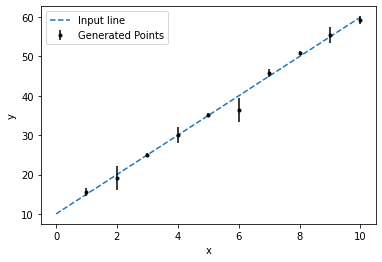

In [9]:
# fill np arrays with the data to be fit:
# build up a line and randomly distribute points around it
a_in = 5.
b_in = 10.
# plot this
xends = np.linspace(0.,10.,2) # Only need to points to draw a line
dum=plt.plot(xends,linfunc(xends,a_in,b_in),"--",label="Input line")
dum=plt.xlabel("x")
dum=plt.ylabel("y")
x_data = np.linspace(1.,10.,10)
y_data = np.empty(x_data.size)  # leave it empty for now
y_err  = np.array([1.0, 3.0, .5, 2.,.5, 3.0,1.,.5,2.,1.])
# Now distribute points around this line.  There are cuter ways to do it, but this
# is more pedagogical
for i in range(0,x_data.size):
    y_data[i] = linfunc(x_data[i],a_in,b_in)+np.random.normal(0.,y_err[i])
dum=plt.errorbar(x_data, y_data, y_err, fmt="k.", 
             label="Generated Points")
dum=plt.legend()

Fit: chi2/NDF=0.55, slope = 5.04, intercept=10.03


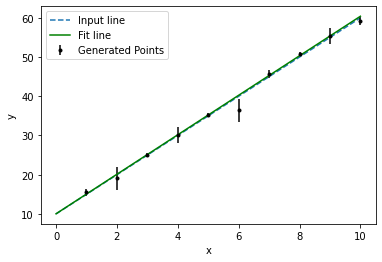

In [10]:
# Now let's fit it with our linear regression program
a_fit,b_fit = lfit(x_data,y_data,y_err)
# Calculate the Chi2/NDF
NDF=x_data.size-2
pred = linfunc(x_data,a_fit,b_fit)
chi2ndf = chi2(y_data,pred,y_err)/NDF
print("Fit: chi2/NDF=%.2f, slope = %.2f, intercept=%.2f"%(chi2ndf,a_fit, b_fit))
# Plot Everything
dum=plt.plot(xends,linfunc(xends,a_in,b_in),"--",label="Input line")
dum=plt.xlabel("x")
dum=plt.ylabel("y")
dum=plt.errorbar(x_data, y_data, y_err, fmt="k.", 
             label="Generated Points")
dum=plt.plot(xends,linfunc(xends,a_fit,b_fit),"g-",label="Fit line")
dum=plt.legend()

Fit: chi2/NDF=0.55, slope = 5.04, intercept=10.03


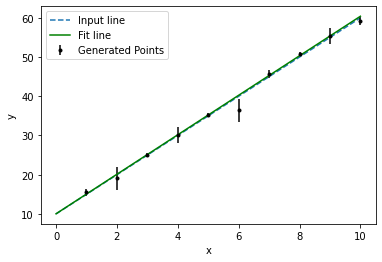

In [11]:
# Now fit with curve_fit
par, cov = optimize.curve_fit(linfunc,x_data,y_data,sigma=y_err)
a_fit=par[0]
b_fit=par[1]
# Calculate the Chi2/NDF
NDF=x_data.size-2
pred = linfunc(x_data,a_fit,b_fit)
chi2ndf = chi2(y_data,pred,y_err)/NDF
print("Fit: chi2/NDF=%.2f, slope = %.2f, intercept=%.2f"%(chi2ndf,a_fit, b_fit))
# Plot Everything
dum=plt.plot(xends,linfunc(xends,a_in,b_in),"--",label="Input line")
dum=plt.xlabel("x")
dum=plt.ylabel("y")
dum=plt.errorbar(x_data, y_data, y_err, fmt="k.", 
             label="Generated Points")
dum=plt.plot(xends,linfunc(xends,a_fit,b_fit),"g-",label="Fit line")
dum=plt.legend()

Fit: raw chi2/NDF=4.26, slope = 1.54, intercept=2.33


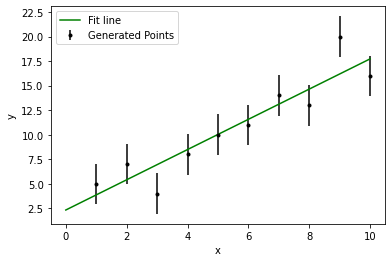

In [12]:
# Estimate errors
# Build up some new data points
y_data = np.array([5.,7.,4.,8.,10.,11.,14.,13.,20.,16.])
# Now fit it without the errors
par, cov = optimize.curve_fit(linfunc,x_data,y_data,absolute_sigma=True)
a_fit=par[0]
b_fit=par[1]
# Calculate the Chi2/NDF assuming unit errors
NDF=x_data.size-2
pred = linfunc(x_data,a_fit,b_fit)
chi2ndf = chi2(y_data,pred)/NDF
print("Fit: raw chi2/NDF=%.2f, slope = %.2f, intercept=%.2f"%(chi2ndf,a_fit, b_fit))
# Use this to estimate the error
y_err = np.full(x_data.size,np.sqrt(chi2ndf))
# Plot Everything
dum=plt.xlabel("x")
dum=plt.ylabel("y")
dum=plt.errorbar(x_data, y_data, y_err, fmt="k.", 
             label="Generated Points")
dum=plt.plot(xends,linfunc(xends,a_fit,b_fit),"g-",label="Fit line")
dum=plt.legend()

Fit: raw chi2/NDF=1.00
slope = 1.54 +- 0.23
intercept = 2.33 +- 1.41


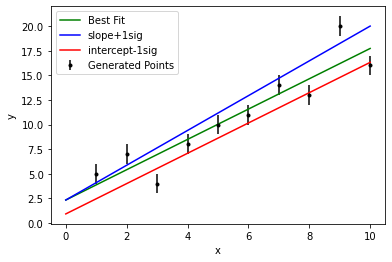

In [13]:
# Now let's check get the errors on the points
# Redo the fit with the calculated errors
par, cov = optimize.curve_fit(linfunc,x_data,y_data,sigma=y_err,absolute_sigma=True)
a_fit=par[0]
b_fit=par[1]
# Calculate the Chi2/NDF assuming unit errors
NDF=x_data.size-2
pred = linfunc(x_data,a_fit,b_fit)
chi2ndf = chi2(y_data,pred,y_err)/NDF
perr = np.sqrt(np.diag(cov))  # Error on points
print("Fit: raw chi2/NDF=%.2f"%(chi2ndf))
print("slope = %.2f +- %.2f"%(a_fit, perr[0]))
print("intercept = %.2f +- %.2f"%(b_fit, perr[1]))
# Use this to estimate the error
y_err = np.full(x_data.size,np.sqrt(chi2ndf))
# Plot Everything
dum=plt.xlabel("x")
dum=plt.ylabel("y")
dum=plt.errorbar(x_data, y_data, y_err, fmt="k.", 
             label="Generated Points")
dum=plt.plot(xends,linfunc(xends,a_fit,b_fit),"g-",label="Best Fit")
# Now plot with some errors
dum=plt.plot(xends,linfunc(xends,a_fit+perr[0],b_fit),"b-",label="slope+1sig")
dum=plt.plot(xends,linfunc(xends,a_fit,b_fit-perr[1]),"r-",label="intercept-1sig")
dum=plt.legend()

In [14]:
# Generate Nsignal events according to a Guassian distribution 
mu = 10.
sig = 3.
Nsignal=1000
ssig  = np.random.normal(mu,sig,Nsignal)

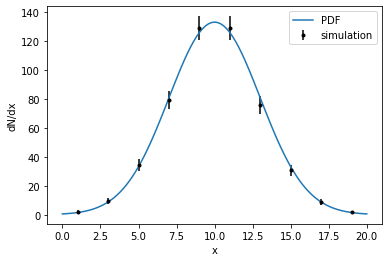

In [15]:
# Histogram them with arbitrary bin sizes
plotrange = (0.,20)
Nbins = 10
hist,bins = np.histogram(ssig,Nbins,plotrange)
hist_error = np.sqrt(hist)
hist_error = np.clip(hist_error,1.,None) # If the sqrt is 0, set it to 1.
binsize = bins[1]-bins[0]
binloc = bins[0:-1]+.5*binsize    # Move location to the middle of the bin
hist = hist/binsize               # Normalize
hist_error = hist_error/binsize   # Normalize error
plt.errorbar(binloc, hist, hist_error, fmt="k.", 
             label="simulation")
xlin = np.linspace(0.,20.,101)
pl=plt.plot(xlin,Nsignal*stats.norm.pdf(xlin,loc=mu,scale=sig),label="PDF")
xl=plt.xlabel("x")
yl=plt.ylabel("dN/dx")
leg = plt.legend()

In [16]:
# Now let's do a fit of this distribution to a Gaussian
def fit_func(x,N,mu,sig):
    val = N*np.exp(-(x-mu)**2/2/sig**2)
    val = val/sig/np.sqrt(2*np.pi)
    return val

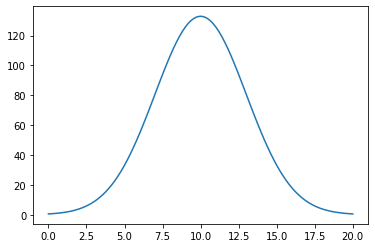

In [17]:
# test
plt.plot(xlin,fit_func(xlin,Nsignal,mu,sig))

In [18]:
# Now let's fit it
par, cov = optimize.curve_fit(fit_func, binloc, hist, sigma=hist_error,absolute_sigma=True)
pred = fit_func(binloc,par[0],par[1],par[2])
NDF = Nbins-3 # 3-parameter fit.  Normalization no longer a constraint
chi2 = ((pred-hist)**2/hist_error**2).sum()/NDF
perr = np.sqrt(np.diag(cov))
print('Best fit: Chi2/NDF=%.3f'%(chi2))
print('    N=%.1f +- %1f'%(par[0],perr[0]))
print('    mu=%.2f +- %2f'%(par[1],perr[1]))
print('    sig=%.3f +- %3f'%(par[2],perr[2]))


Best fit: Chi2/NDF=0.170
    N=998.5 +- 31.609781
    mu=9.92 +- 0.095119
    sig=2.991 +- 0.070688


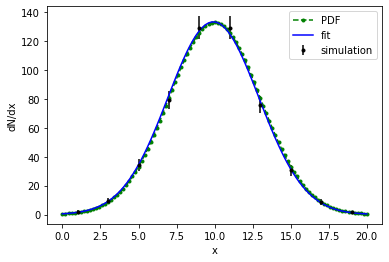

In [19]:
# Plot all three
plt.errorbar(binloc, hist, hist_error, fmt="k.", 
             label="simulation")
xlin = np.linspace(0.,20.,101)
pl=plt.plot(xlin,Nsignal*stats.norm.pdf(xlin,loc=mu,scale=sig),"g.--",label="PDF")
pl=plt.plot(xlin,fit_func(xlin,par[0],par[1],par[2]),"b",label="fit")
xl=plt.xlabel("x")
yl=plt.ylabel("dN/dx")
leg = plt.legend()

In [21]:
# Returns N 1-D random numbesr based on the function myfunc, in the range xlo to xhi
# funcmax is the maximum value of funcmax
#
def mydist(func,N=1,xlo=0.,xhi=1.,funcmax=1.):
    s = np.empty(N)         # Generate an empty vector N long
    for i in range(0,N):   
        while (True):       # Loop until we find a "good" number
            x = np.random.uniform(xlo,xhi)
            if(func(x)>=funcmax*np.random.uniform()):
                break       # Exit the generation loop
        s[i]=x
    return s

In [22]:
# Background function
def backfunc(x):
    return a_background*x+b_background

In [23]:
#Generate a signal and linear background
# Gaussian signal
N_signal = 100
mu_signal = 30.
sig_signal = 1.5
# (Unnormalized!) Linear background
N_background = 1000
a_background = -2.   # slope of background
b_background = 120.   # intercept of background
# Generate the signal
sig = np.random.normal(mu_signal,sig_signal,N_signal)
# Generate the background
back = mydist(backfunc,N_background,0.,50.,b_background)

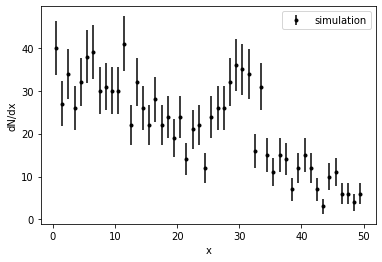

In [24]:
# Combine the samples and histogram
data = np.append(sig,back)
plotrange = (0.,50)
Nbins = 50
hist,bins = np.histogram(data,Nbins,plotrange)
hist_error = np.sqrt(hist)
hist_error = np.clip(hist_error,1.,None) # If the sqrt is 0, set it to 1.
binsize = bins[1]-bins[0]
binloc = bins[0:-1]+.5*binsize    # Move location to the middle of the bin
hist = hist/binsize               # Normalize
hist_error = hist_error/binsize   # Normalize error
plt.errorbar(binloc, hist, hist_error, fmt="k.", 
             label="simulation")
xl=plt.xlabel("x")
yl=plt.ylabel("dN/dx")
leg = plt.legend()

In [28]:
# Linear + gaussian fit function
def sigfit(x,a,b,N,mu,sig):
    lin = a*x+b
    gauss = N*stats.norm.pdf(x,loc=mu,scale=sig)
    return lin+gauss

In [29]:
# Now let's fit it
# Guess
guess = np.array([40.,-1.,10.,30.,1.])
#guess = None
par, cov = optimize.curve_fit(sigfit, binloc, hist, 
            p0=guess,sigma=hist_error,absolute_sigma=True)
pred = sigfit(binloc,par[0],par[1],par[2],par[3],par[4])
NDF = Nbins-5 # 5-parameter fit.  Normalization no longer a constraint
chi2 = ((pred-hist)**2/hist_error**2).sum()/NDF
perr = np.sqrt(np.diag(cov))
print('Best fit: Chi2/NDF=%.3f'%(chi2))
print('    a=%.1f +- %1f'%(par[0],perr[0]))
print('    b=%.2f +- %2f'%(par[1],perr[1]))
print('    N=%.1f +- %1f'%(par[2],perr[2]))
print('    mu=%.2f +- %2f'%(par[3],perr[3]))
print('    sig=%.3f +- %3f'%(par[4],perr[4]))

Best fit: Chi2/NDF=1.175
    a=-0.6 +- 0.038716
    b=34.34 +- 1.445889
    N=101.2 +- 17.934987
    mu=29.88 +- 0.383427
    sig=2.022 +- 0.385223


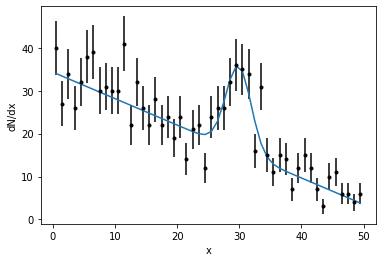

In [30]:
# Plot them both
plt.errorbar(binloc, hist, hist_error, fmt="k.", 
             label="simulation")
plt.plot(binloc,pred,label="best fit")
xl=plt.xlabel("x")
yl=plt.ylabel("dN/dx")